**Cole, Ethan, Alice**

Spring 2020

CS 443: Computational Neuroscience

Project 3: Competitive Networks

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overview of the working memory task

The purpose of this notebook is to take all the "bulding block" dynamics networks that you have played with and use them for a larger simulation. You will apply dynamic neural network equations to simulating human working memory storage and retrieval.

An example of this problem is giving you my phone number (you've never heard it before) and asking you to recall it back to me. There are 10 items to store temporarily in working memory: 207 550-4567. It's important to store their **order** (not only the **item identity** themselves) — e.g. 2, then 0, then 7, ...

Task 5 **recalls/extracts items already stored from working memory in the correct order**. Task 6 is concerned with getting items queued up in **working memory storage** (STORE2 network). **In light of timing constraints, this is now a suggested extension.**

**NOTE:** You are welcome to use your language of choice to implement the neural networks (i.e. Python or MATLAB). These instructions are provided in a Jupyter notebook in case you have trouble accessing MATLAB.

There are no code templates for this part — you may design the network how ever you like. In each task, there are key plots that you are asked to replicate to show that everything is working.

## Task 5) Serial Recall: Competitive Queuing

### Overview of the serial recall task

In this task, you will create a 3 level network (one is a winner-take-all RCF) called a **competitive queuing model (CQ)** that will retrieve each item in the appropriate order from working memory (if we have 4 items in working memory, ABCD, the CQ should retrieve A then B then C then D).

You can download from the website use the output from $x$ at the last time step from STORE2 to initialize this new CQ network that will perform the list recall. *If you do the Task 6 extension, you can compute these memory gradients yourself.*

### Competitive Queuing network

This network consists of three interconnected layers.
- There is an working memory layer $x$ (first layer) like before
- a second layer $y$ which is a RCF with a faster-than-linear signal function such that it creates winner-take-all dynamics
- and there is another layer of **inhibitory interneurons** $w$ will are in charge of inhibiting / shutting down cells coding an item from working memory after it gets recalled (i.e. the item has been recalled and can't interfere with recall of later items). 

Here is a brief review of the neural network dynamics. Cells in $x$ initially encode the primacy gradient from STORE2. At some point that you choose, a GO signal occurs ($J$ flips from 0 to 1). This prompts recall of the list in working memory. Cells in the RCF ($y$) start to compete. The RCF cell $y_k$ encoding Item 1 wins the competition (1st item has the highest activity). This activates the inhibitory neuron $w_k$, which suppresses $x_k$ to 0. Without any input, the winner RCF cell $y_k$ activity drops down. The working memory cells $x_i$ re-normalize activity, bringing everybody up. Now the RCF cell for the 2nd item $y_m$ gets the most input $x_m$, which makes it win the competition. It then activates $w_m$, which suppresses $x_m$ and the cycle continues until all items have been recalled from the network. 

Here are the equations for each layer:

$$\frac{x_i}{dt} = -A_xx_i + (B_x - x_i)f(x_i)- x_i  \left (\sum_{j\neq i}x_j +Dw_i \right )$$

$$\frac{y_i}{dt} = -A_yy_i + (B_y-y_i)(y_i^2+Jx_i) - (C_y+y_i)\left (\sum_{j\neq i}y_j^2 \right )$$

$$\frac{w_i}{dt} = -A_ww_i + (B_w - w_i)\text{max}(y_i - \Gamma, 0)$$

$$f(x_i) = x_i/\left (\epsilon + \sum_{j=1}^Nx_j \right )$$

Above, the parameters follow the usual conventions with the following notes:
- $D$ regulates the inhibitory feedback strength from the interneurons.
- $J$ is 1 if the GO signal has been turned on and is 0 otherwise. The GO signal turns at at a time $t_{go}$ of your choosing to initiate recall of the list. $J$ should be 1 for ALL times after $t_{go}$.
- $\epsilon$ is a small number to prevent division by 0 if all the working memory cells are 0.
- $\Gamma$ is a threshold: the amount of RCF activity needed for a clear winner to be established so that the corresponding item in working memory can be triggered for recall to initiate the suppression of the working memory representation. 

A few more guidelines/suggestions:
- The initial conditions for the $x_i$ cells should be set to the STORE2 primacy gradient final values. **I suggest explicitly normalizing these initial values so that they all sum to 1 before setting the initial conditions.**
- After working memory units are suppressed (following recall), it might be helpful to "tag" these cells so that they are hard-coded to 0 (i.e. manually shut off) for all later times based on the cell index of each winner. That way, you don't have to worry about them potentially becoming active again interfering with the other cells. I would caution against a hard threshold value to check against because it won't allow your network to scale if you want to more items for your network to remember.

### Goals

The design of the network and parameters are up to you. The goal is to get the network to recall items from working memory robustly for for lists at least of length 3-6 items. Here is an example of a plot that you can try to emulate from Boardman & Bullock (1991) (annotations are mine to highlight key parts of the plot):

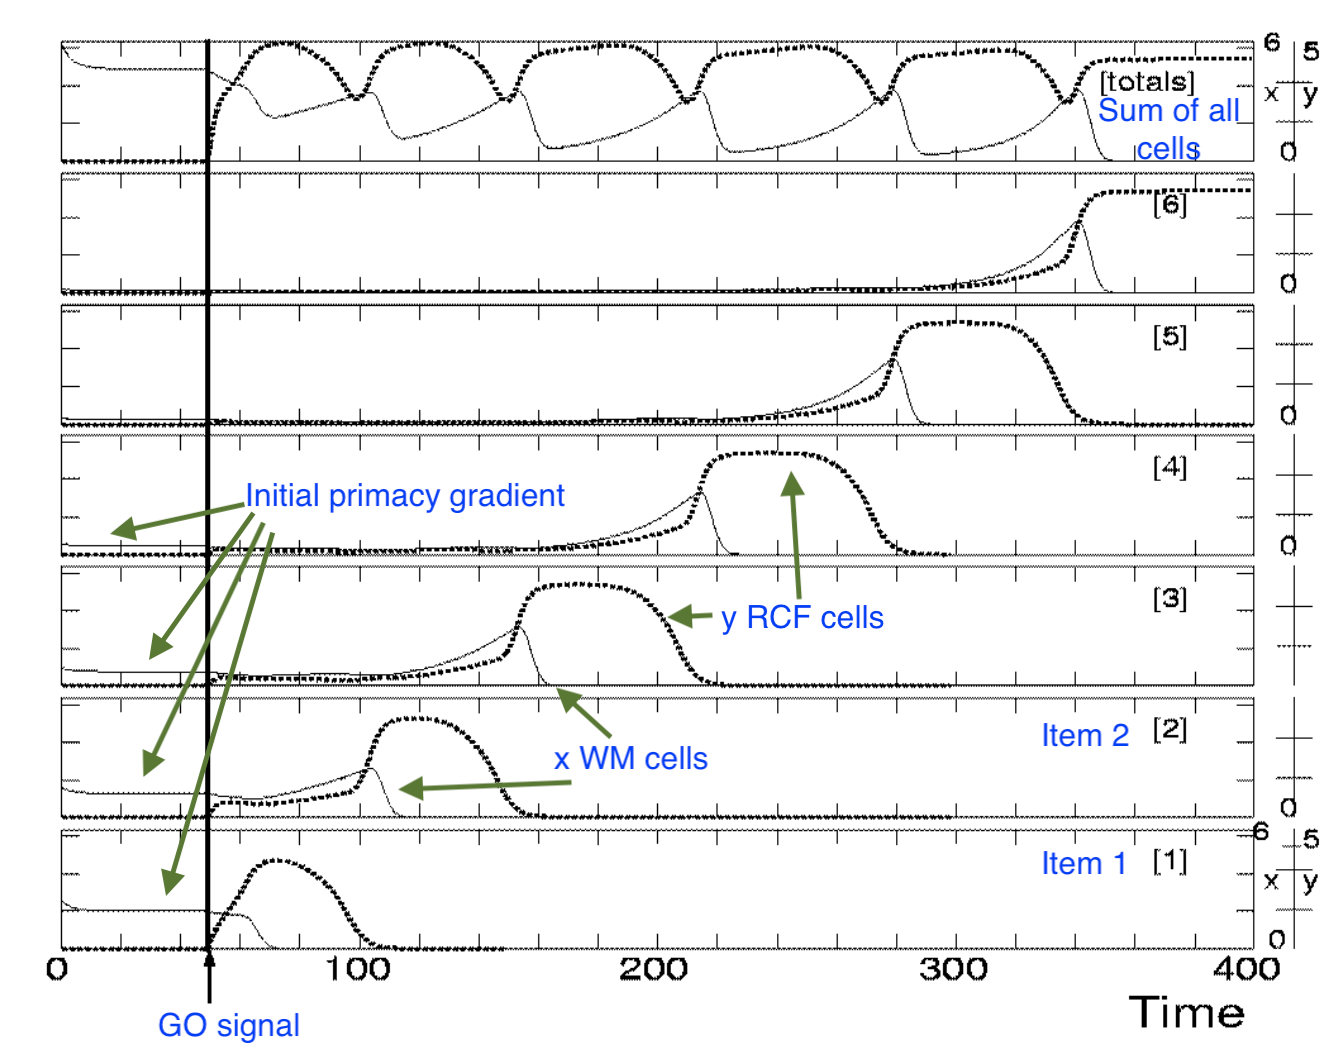

An important learning outcome is learning how to debug a complex interacting system. This involves picking parameters to make the network achieve the goal based on the meaning of each parameter. However, I don't want you to spend hours tuning parameters. Here are some suggestions:
- Use "reasonable" values in ranges that you're used to seeing.
- Start simple with 1-2 items, get it working, then increase from there.
- The feedback strength from inhibitory interneurons ($w_i$) and working memory units ($x_i$) should be very strong. You want the interneuron to very quickly suppress the working memory activation $x_i$.
- The inhibitory interneuron decay rate should be very small: If we are suppressing a working memory item, we want to suppress it for future times so that it doesn't reactivate for some reason.
- The RCF ($y$) to inhibitory interneuron threshold ($w$) should be set based on what you see as an activity level RCF *winners* achieve, but the losers do not (hitting this threshold means a snowball effect is triggered).
- If your RCF is getting input from the working memory cells appropriately, but a clear winner isn't emerging, try increasing B.
- If your RCF winner isn't dropping back to 0, try increasing C.
- When plotting, restrict the y axis to positive values (e.g. RCF winners will drop down to negative values and you probably want to focus on the positive activity).
- If using MATLAB, use the MATLAB debugger to enter the network integration loop at certain time steps where you "need" something to happen (e.g. if $t > 50$ stop at a break point), then adjust parameters based on what you discover in the debugger (you need an RCF cell to get higher activity so you increase B, you need the RCF cell to decay back to 0 so you increase C, etc).
- Everyone's time scale will differ depending on parameter choices — there are many, many valid parameter combinations that will let the network operate effectively.

If you are spending too much time on tuning parameters, please see the parameter hints file (cq_parameter_hints_1.txt) for some values that work so you have fewer parameters to play with. If that's not enough and you're still not having luck, check out (cq_parameter_hints_2.txt) for more parameters.

### Plots

You should submit the following plots inline in this notebook or in your submission folder:

- Figure showing the working memory cells and RCF cells over time (and maybe the interneurons too) in a number of rows equal to the number of items in memory. The figure should look roughly like the one above. Like before, there's no need to reproduce magnitudes, timing of recall events, etc. The important thing is to get the general picture/dynamics working for parameters that you discover.
    - All items queued up into working memory should be dynamically dequeued in the appropriate order.
    - Each panel should show the RCF cells "spiking", which corresponds to the item being recalled, and the working memory representation dropping to 0 afterwards.
    - A "Totals" row (summed activity across all cells) is optional.

In [31]:
import cq_net as cq
cqnet = cq.CQNet(num_gradients=10)
x_hist, y_hist, w_hist = cqnet.competitive_queue(I = cqnet.get_x(), decay_x=0.5, decay_y=1, decay_w=.01, capacity_x=1.0, capacity_y=2.0, capacity_w=1.0, feedback_strength = 1000, go_signal =1.9, lower_bound = 0, threshold = .55)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]


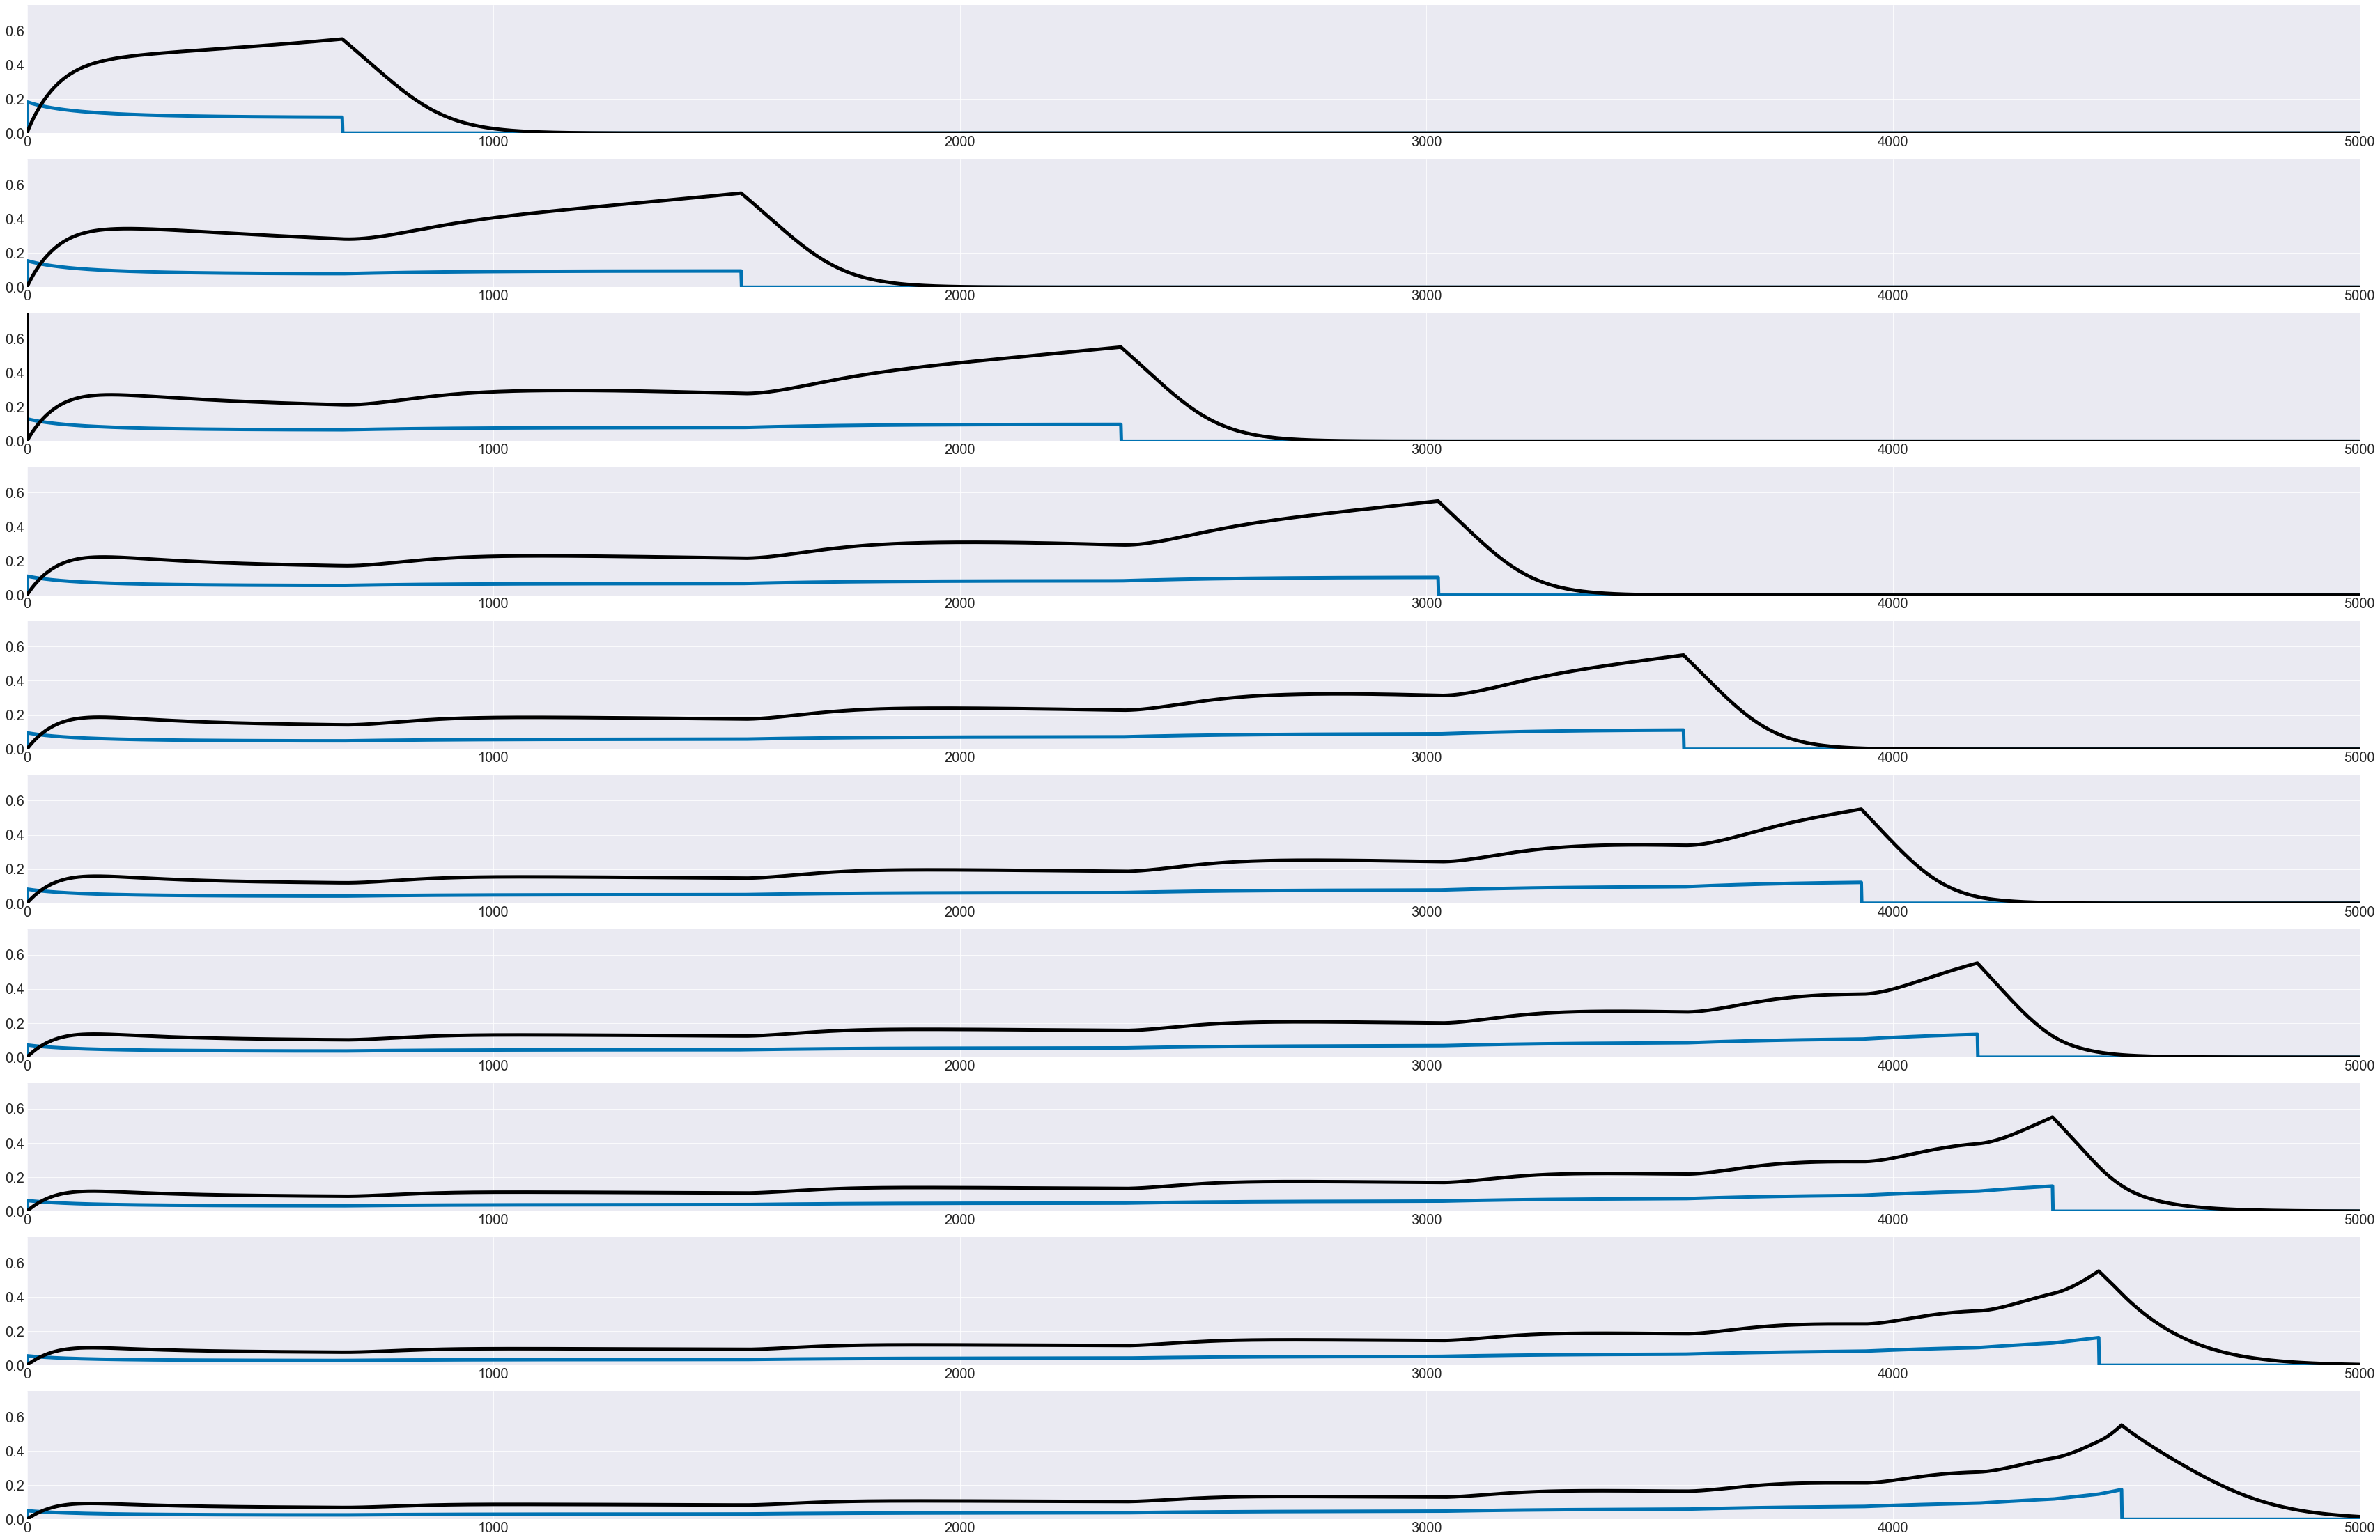

In [32]:
fig = plt.figure(figsize=(60, 40))

# # the summed one
# a = fig.add_subplot(N+1, 1, 1)
# a.plot(np.sum(x_hist, axis=1), lineWidth=5)
# a.plot(np.sum(y_hist, axis=1), lineWidth=5)

N = x_hist.shape[1]
for i in range(N): 
    a = fig.add_subplot(N, 1, i+1)
    a.plot(x_hist[:, i], lineWidth=5, label='working memory')
    a.set_ylim(ymin=0, ymax=.75)
    a.set_xlim(xmin=0, xmax=5000)
    a.plot(y_hist[:, i], c='black', lineWidth=5, label='RCF')

### Questions

**Question 16:** What happens when you "pause" the GO signal for some period of time after it goes on (i.e. set it to 0 manually for some period of time after it is 1, then bring it back to 1 after this pause period is over)?

**Question 17:** Is there a limit on how many items can your network recall?

### Answers

**Answer 16:** When we pause our Go Signal, the network returns nothing for the timesteps that it is paused. Then, when it is reinstated, it continues returning values. 


**Answer 17:** We can recall 13 items, see our first extension for an in depth analysis of this.

## Task 6) Working Memory Storage: STORE2 network [EXTENSION]

You will implement the STORE2 model from Bradski et al. (1994) that encodes each item and order in a type of neural signal called a **primacy gradient**. The STORE2 network consists of two dynamically interacting layers of neurons. The first one  is the working memory representation we're interested in. The second layer  tracks the first one and you can think of as a "helper" layer. Here are the equations:

$$\frac{dx_i}{dt} = I \left (AI_i + y_i - Xx_i - Bx_i \right )$$
$$\frac{dy}{dt} = E\left ( x_i - y_i \right ) \left (1 - I \right )$$

where:

- $x_i$ is the activation of the $i^{th}$ working memory cell (layer 1) (in the telephone example $i$ would go from 1 to 10 since there are 10 items to encode)
- $A, B, E$ are parameters as we have discussed in class, 
- $y_i$ are the corresponding cell activities in the second layer (there are equal numbers of cells in the two layers), 
- $I$ is defined as the sum of all inputs currently on ($I = \sum_i^N I_i$), and 
- is the sum of all the working memory cell activites at the current time ($X = \sum_i^N x_i$).

### Input specification

We will assume that each item being presented to the network comes in one at a time with magnitude 1 (i.e. $I_i$ when the $i^{th}$ input turns on) and is 0 otherwise (when the item is not being presented). For example, the 1st item to be remembers comes first, followed by the second item, etc. There should be a small gap between items (like in real life) where all inputs are 0. The $j^{th}$ item in the sequence should be presented ONLY to the $i^{th}$ working memory unit  as follows, where  is defined in CONTINUOUS TIME UNITS (e.g. 0, 0.1, 0.2, ...):

$$I_j = 1\,\,\, \text{if} (j-1)(a+b) < t < j*a+(j-a)b$$
$$0 \text{ otherwise}$$

In the above input equation, $a$ is the duration that each item is presented and $b$ is the gap/interval between two subsequent item presentations.

### Goals

Your goal is to implement STORE2 and create primacy gradient encoding 3 items, like the one in the following figure. 

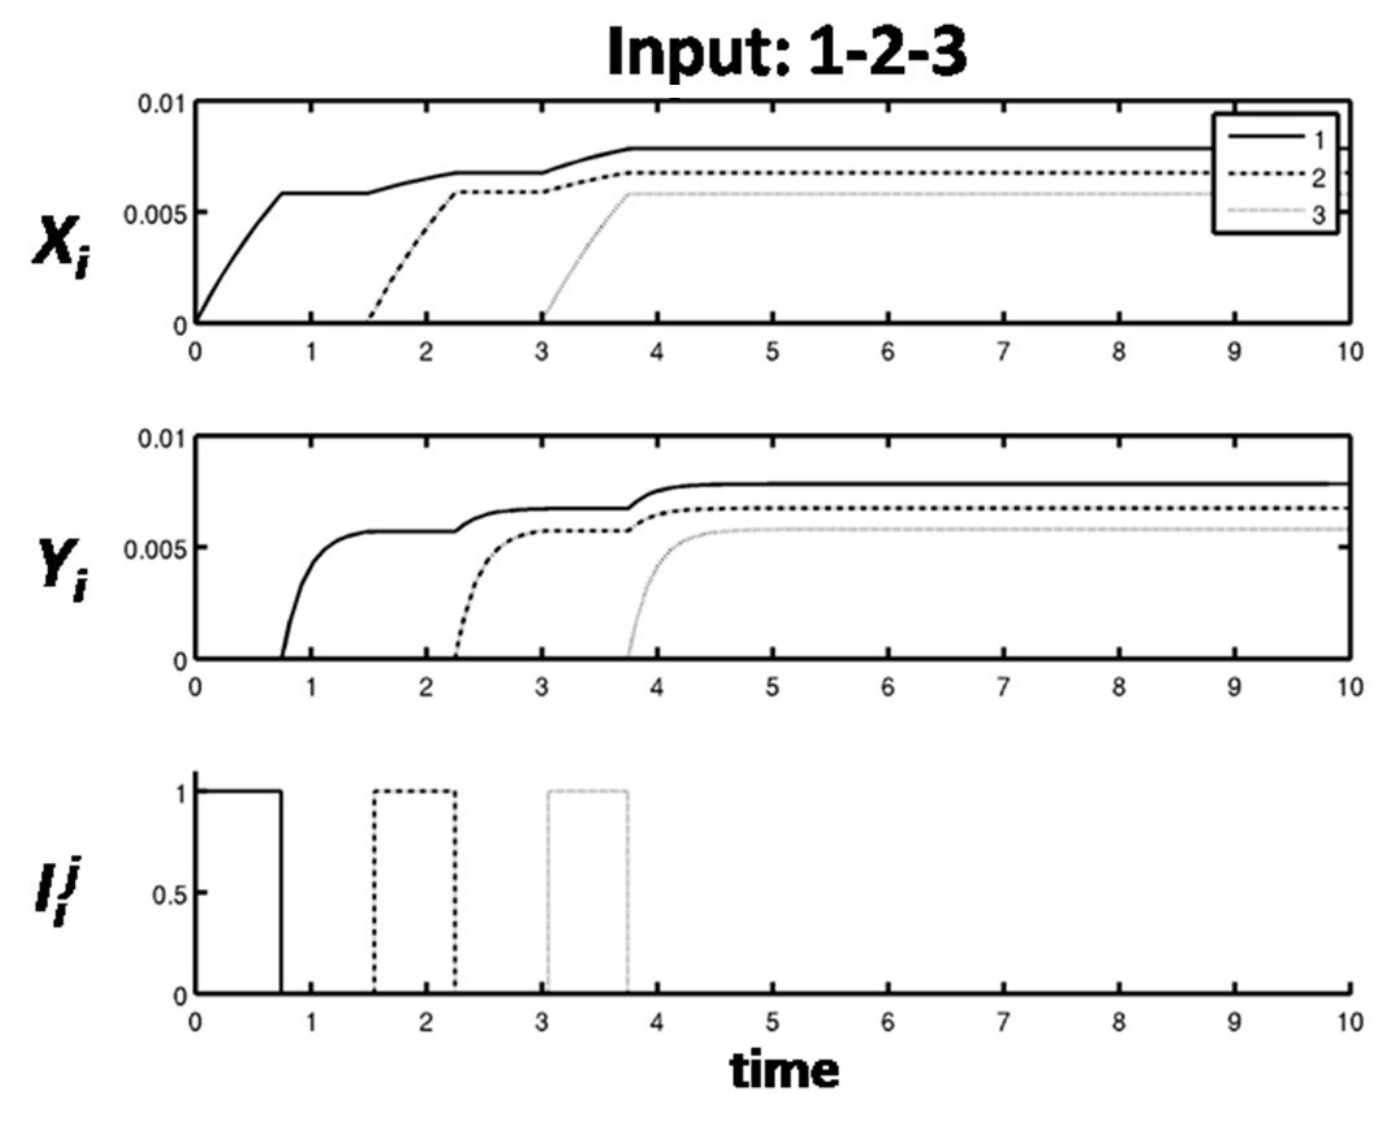

As mentioned at the top, the design of the network is up to you. Ultimately, however, you should compute/return variables reflected in the plot:

- `I_i(t)`: The input signal history presented to working memory cell $i$ at all times (square waves in above plot).
- `x(t)`: the activity of the working memory cells at ALL time steps of the simulation.
- `y(t)`: same thing, but for the y cells

*There's no need to try and match the exact magnitudes or durations (except the inputs still should be either 0/1)*. You do need to get the shape correct (i.e. clearly encode a primacy gradient). Your network should work with any reasonable number of working memory items > 0, not just 3.

### Deliverable plots

You should submit the following plots inline in this notebook or in your submission folder:

1. 3 row figure showing the inputs, working memory cells, and y cells over time (like figure above). You should show a clear primacy gradient in the x and y cells.
2. After all your inputs are shut off and your network establishes a primacy gradient, take the $x$ values at the final time step and normalize them so those values sum to 1. You should now have a $N$ normalized values ($N$ = number of items).
    - Create a bar plot showing the relative magnitudes in sequence order (activation to item 1 on the left, activation to item 2 next to it, etc). Your plot should show a clear primacy gradient (item 1 has the highest activity, item 2 has the next highest, etc.). The x axis should should item number and y axis should show network activation to it.
3. Play with your network parameters and create a plot with a **recency gradient**, which means that the LAST item garners the highest activity, followed by the second-to-last item, etc.
4. Play with the parameters once again and create a plot showing a **bowing gradient**, which means that the bars look "U-shaped": the largest values are either at the beginning or end of the list and decrease toward the middle.

### Questions

**Question 18:** What role does the parameter B play in the primacy gradient? 

**Question 19:** What does it mean for list item sequence encoding when the network shows a bowing gradient? Give a real-life example where this probably happens.

**Question 20:** Does there seem to be a limit on the number of items that can be stored in working memory in a primacy gradient using STORE2? Why or why not?

**Question 21:** Name one problem may arise for later retrieval if the number of items becomes very large. Does this make sense based on your experience of holding information in working memory?

### Answers

**Answer 18:** Fill me in

**Answer 19:** Fill me in

**Answer 20:** Fill me in

**Answer 21:** Fill me in

## Extensions

For our first extension, we explored the storage limits of the working memory. It recalled the items in order perfectly with a threshold value of 0.55 with up to 12 items. To get it to work perfectly with 13 items, we had to decrease the threshold value to 0.3. It seems as though 13 items is the capacity for our system. When we attempt using the same threshold of 0.3 with 14 items, the program does not stop running, meaning that not all of the items in the winner-take-all layer reach the threshold value. The only value we found where it actually stopped running was 0.1, which returned the first eight values on one time step, followed by the ninth, then the 10th through 13th, followed by the last:

![0 1 2 3 4 5 6 7; 8; 9 10 11 12; 13;](results/threshold0.3.png "14 values with a threshold of 0.3")


This raises the question of why there seems to be a limit on how many items we can store in working memory. The output of the 14-item primacy gradient indicates that multiple items were exceeding the threshold on the same time step, which could mean that the faster-than-linear function is not doing a very good job of separating the inputs from layer x. To see if this was the case, we changed the squaring in the faster-than-linear layer to cubing. The results, though not perfect, are significantly better than before. This is with a threshold of 0.24916. 

![0 1; 2; 3; 4; 5; 6; 7; 8; 9; 10 11; 12 13;](results/cubic_wta.png "14 values with a cubic wta layer and threshold 0.249")


Unfortunately, this seems to be about as well as we can do just by manipulating the exponentiation in the faster-than-linear layer and the threshold value. We could not obtain better results using the fourth power or the tenth power, so it is likely that the computer simply cannot achieve the level of precision necessary in order to return each element of the primacy gradient in order, one after the next. 


### 0. STORE2 network

Some or all of Task 6 above.

### 1. STORE2 primacy gradient
Experiment with the timing, number of items, duration of the items. Is the network robust to these changes?
Try presenting multiple items at the same time to STORE2. What happens?
Come with a scheme for creating primacy gradients for lists with repeat items (hint: the Bradski paper has some methods for doing this).

### 2. Serial recall timing
Analyze the timing of when items are retrieved from working memory. Is the distribution uniform? Does the distribution make sense?
Analyze how changes to the parameters affect the timing and quality of item recall.

#### Extension 3
We can see in the graphs from task five that the recall is not uniform. It takes a while for the first item to get recalled and less for the second until the last items are firing rapidly. This makes sense because over time the cells get normalized. You can see that in a bump amongst all cells each time that another cell drops to zero. This is because as they get re-normalized and the cell drops out, each other cell increases in value. This pushes all the cells closer to the threshold value.  Thus, each timestep at the WTA layer, the cells have less to travel to get to the threshold and there is less competition. Therefore, the first cells take longer to fire than the last cells. 

Currently, the loop runs for 5000 timesteps. This is more than enough time to recall all 10 primacy gradients. Let's adjust a few different parameters pointed at making the network recall in different amounts of time. In theory, a lower threshold should speed up our recall because we don't have as much time spent in competition in the winner-take-all layer. Lets move our threshold value down from .55 to .45.

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]


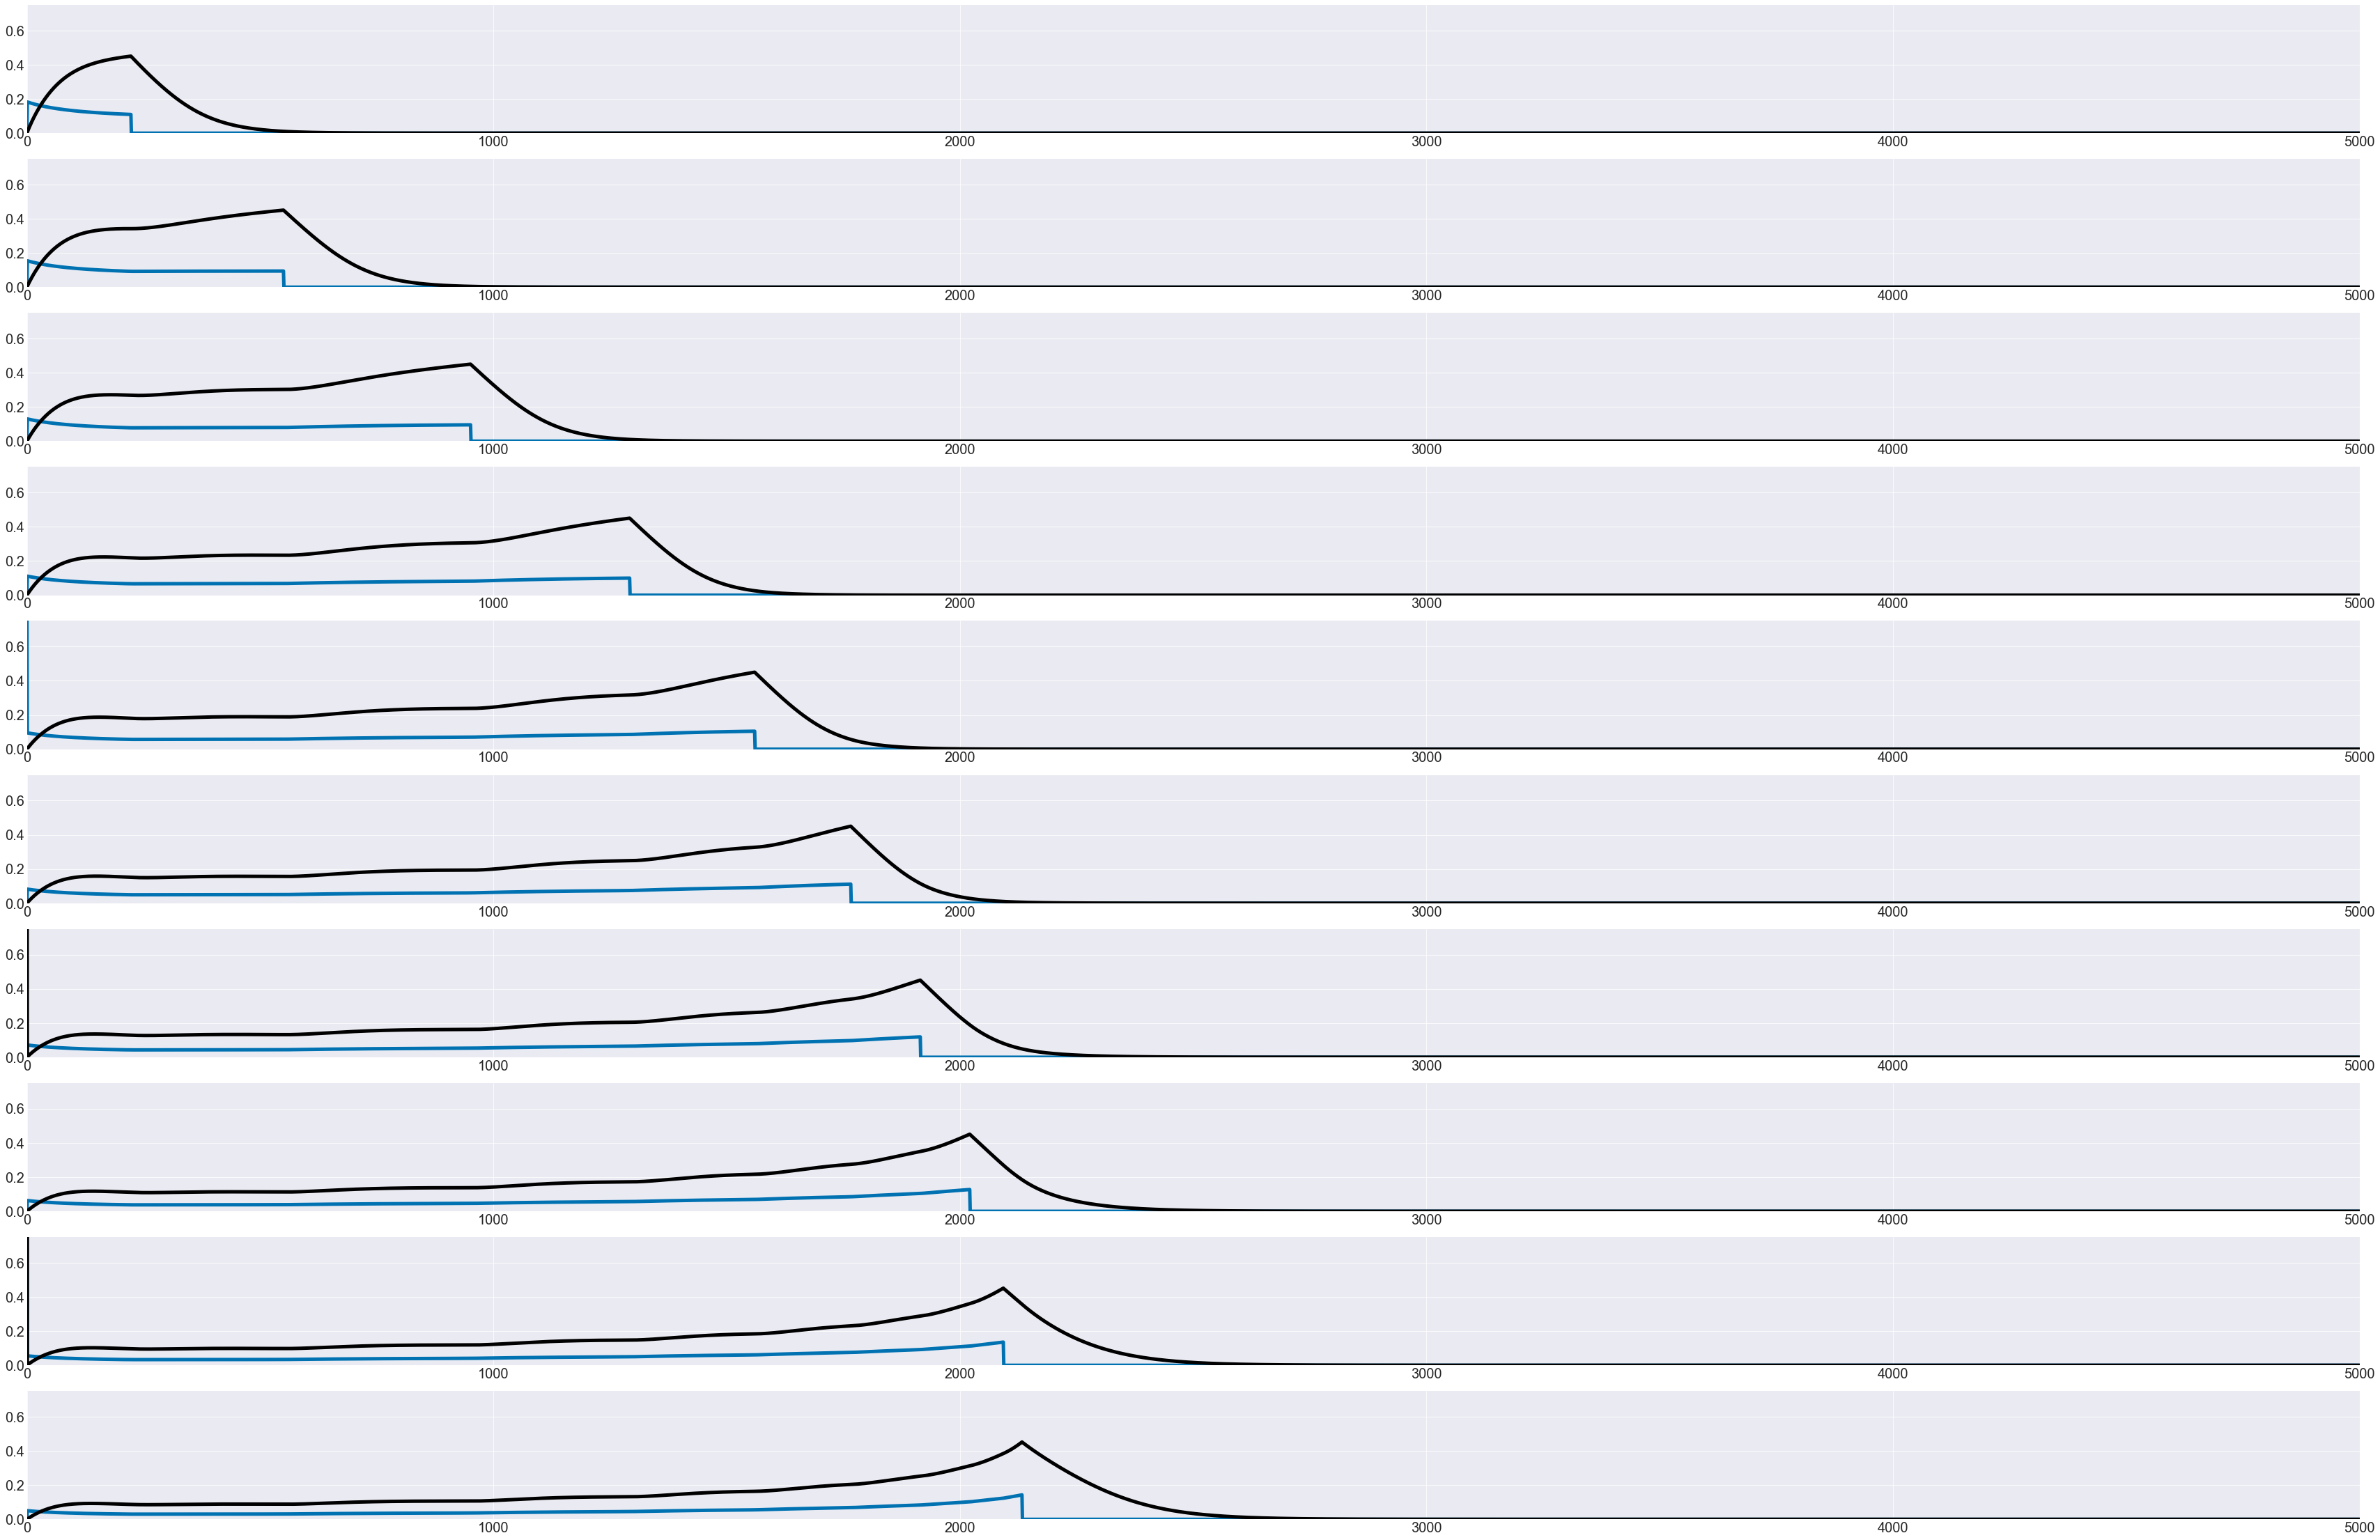

In [34]:
cqnet = cq.CQNet(num_gradients=10, timesteps=5000)
x_hist, y_hist, w_hist = cqnet.competitive_queue(I = cqnet.get_x(), decay_x=0.5, decay_y=1, decay_w=.01, capacity_x=1.0, capacity_y=2.0, capacity_w=1.0, feedback_strength = 1000, go_signal =1.9, lower_bound = 0, threshold = .45)
fig = plt.figure(figsize=(60, 40))

N = x_hist.shape[1]
for i in range(N): 
    a = fig.add_subplot(N, 1, i+1)
    a.plot(x_hist[:, i], lineWidth=5, label='working memory')
    a.set_ylim(ymin=0, ymax=.75)
    a.set_xlim(xmin=0, xmax=5000)
    a.plot(y_hist[:, i], c='black', lineWidth=5, label='RCF')

This appears to be a shocking development in the world of highspeed recall. A 19% decline in the threshold level lead to 50% faster recall rates and no loss in accuracy. We likely lose some stability here because the competition gets fiercer at a lower level. If we think about it, many cells get multiplied up at a timestep but the largest cell that breaks the threshold first gets recalled. But as the threshold lowers, there is ess time spent in competition as the largest cell has to grow less to break the threshold. However, this increases the likelihood that two cells break the threshold at once which would cause all sorts of recall problems. This is the inherent loss of stability that would come with lowering threshold.

Let's try finding the breaking point of the threshold. I am going to lower this until we can see the graph where it breaks.

[0]
[0]
[0]
[0 1]
[2]
[2]
[2]
[2]
[3]
[3]
[3]
[4]
[4]
[4]
[5]
[5]
[6]
[6]
[7]
[7]
[8]
[9]


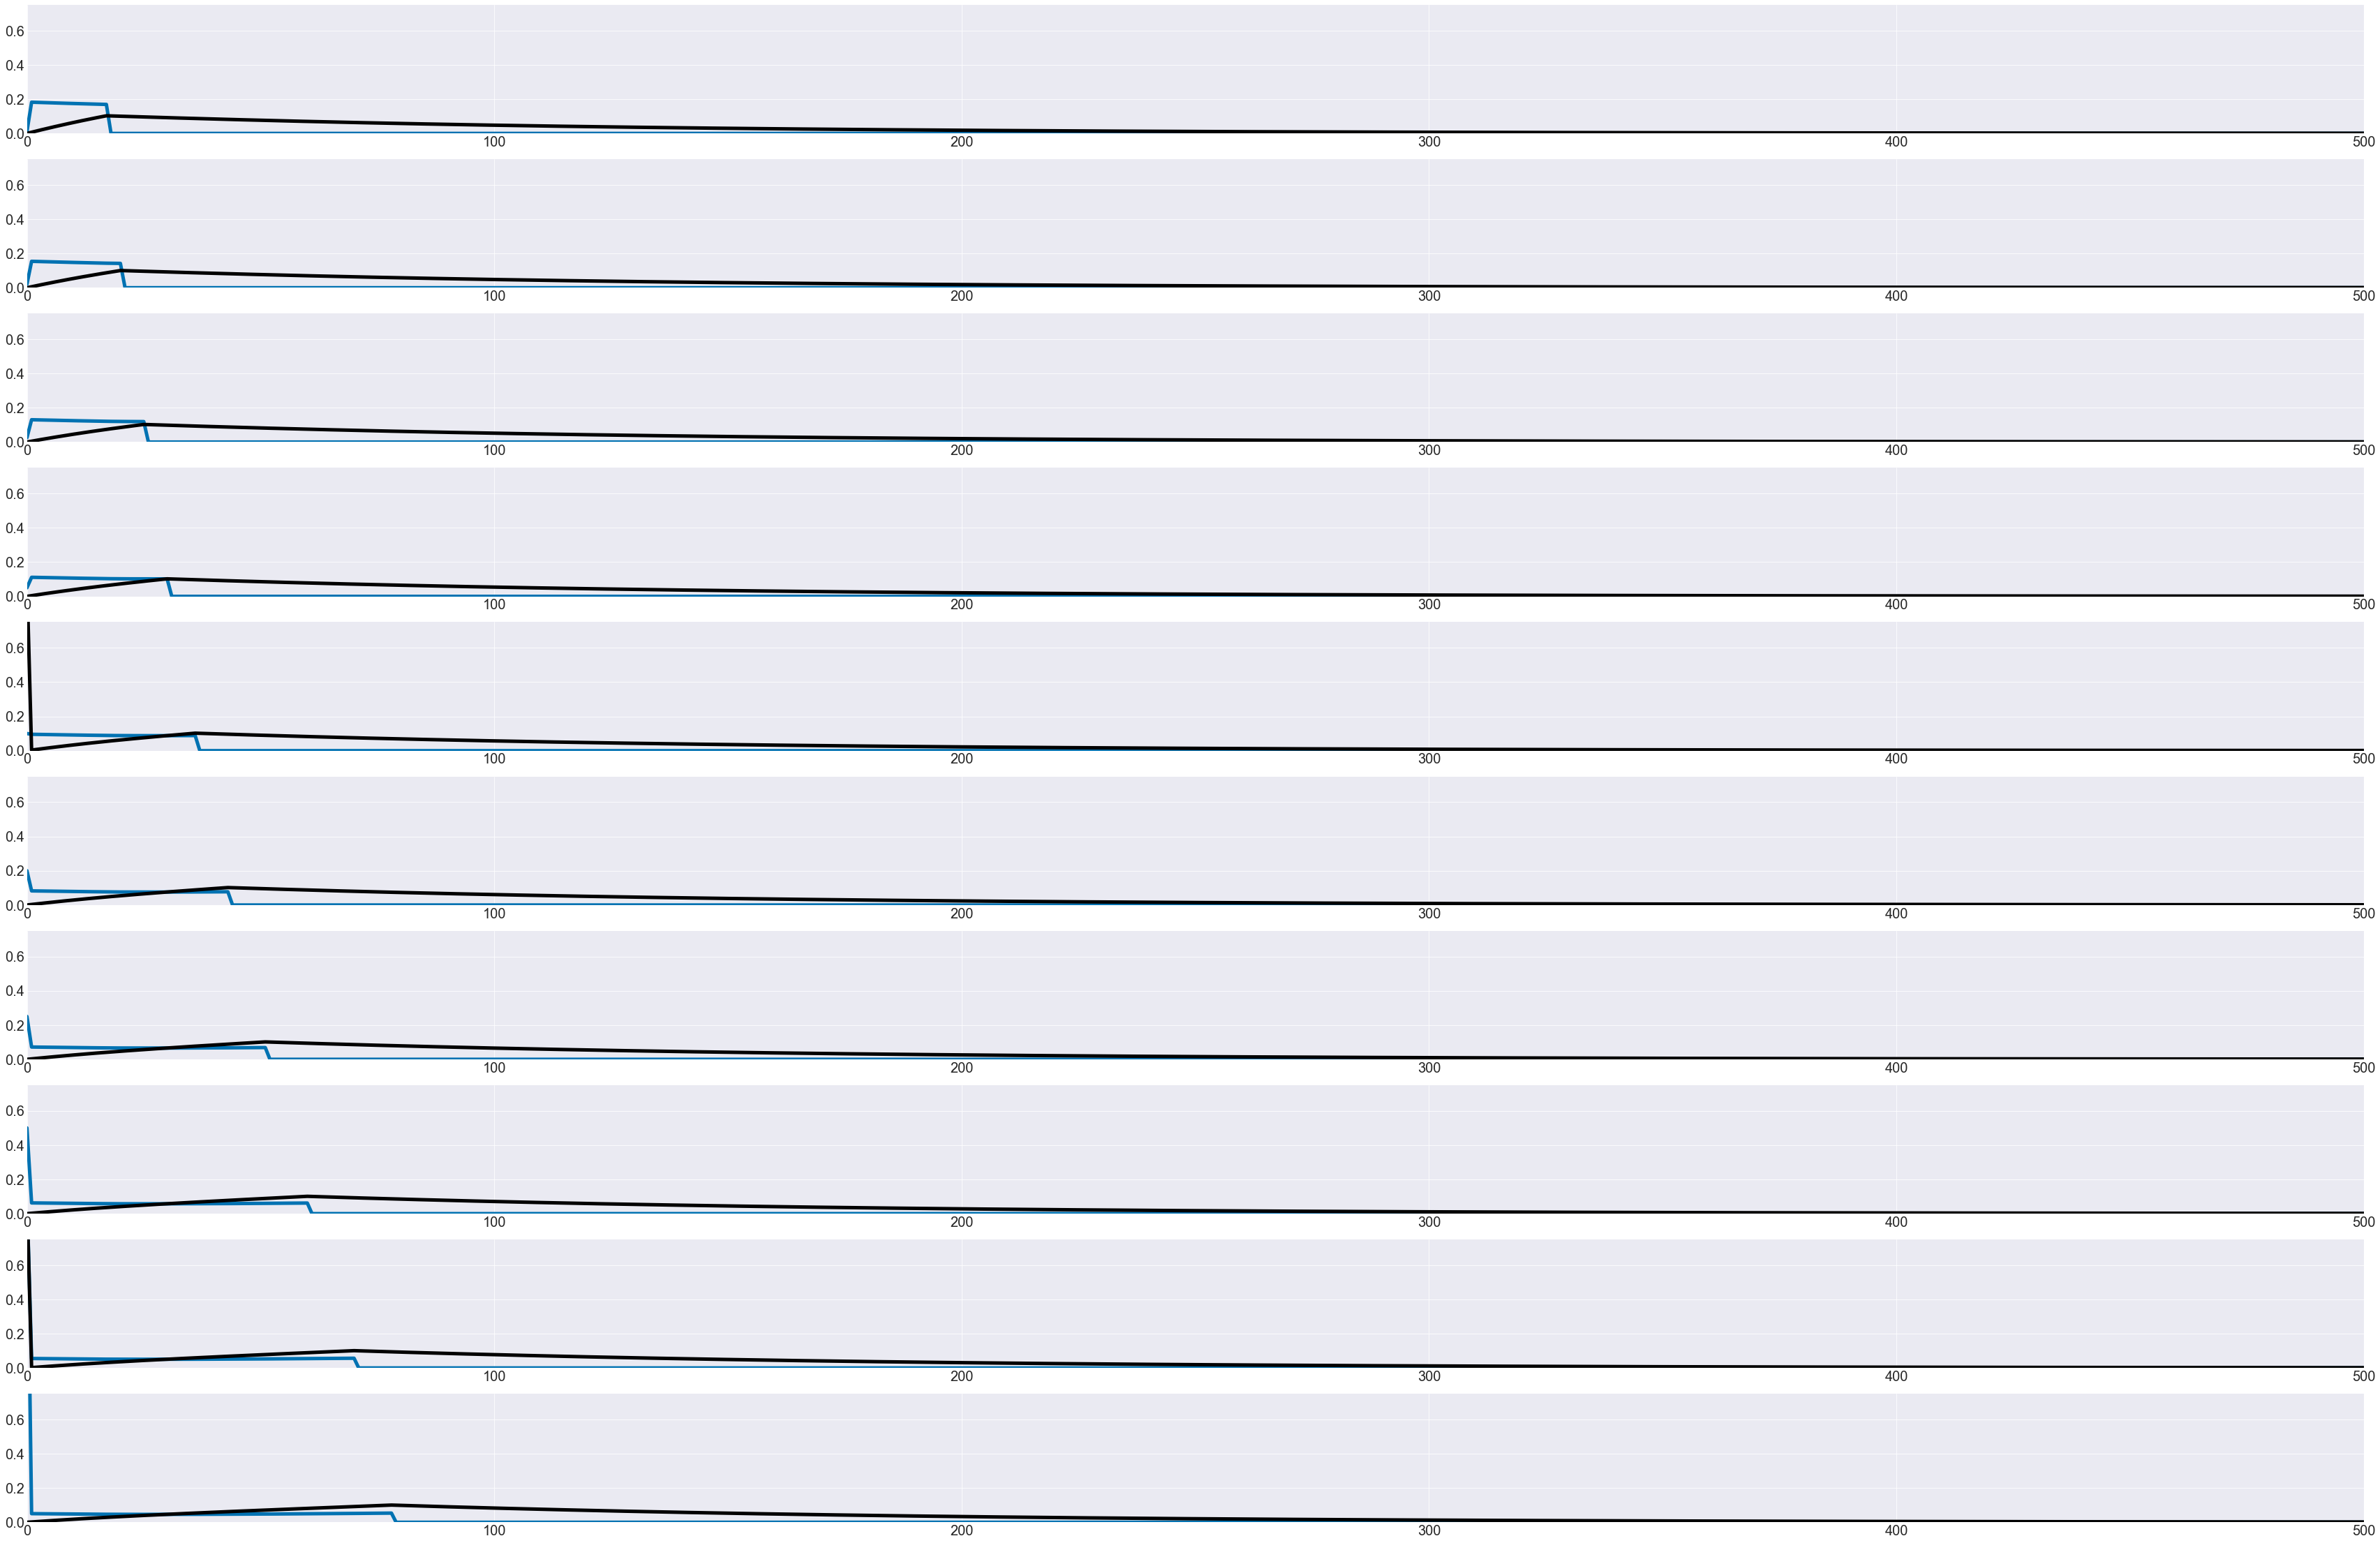

In [40]:
cqnet = cq.CQNet(num_gradients=10, timesteps=5000)
x_hist, y_hist, w_hist = cqnet.competitive_queue(I = cqnet.get_x(), decay_x=0.5, decay_y=1, decay_w=.01, capacity_x=1.0, capacity_y=2.0, capacity_w=1.0, feedback_strength = 1000, go_signal =1.9, lower_bound = 0, threshold = .1)
fig = plt.figure(figsize=(60, 40))

N = x_hist.shape[1]
for i in range(N): 
    a = fig.add_subplot(N, 1, i+1)
    a.plot(x_hist[:, i], lineWidth=5, label='working memory')
    a.set_ylim(ymin=0, ymax=.75)
    a.set_xlim(xmin=0, xmax=500)
    a.plot(y_hist[:, i], c='black', lineWidth=5, label='RCF')

This acts differently with a threshold of .05 than the other network above and looks more like the original image that we are trying to replicate. Notice the y axis has been decreased by an order of magnitude from 5000 timesteps to 500 timesteps. The later neurons appear to taking longer to fire, which makes sense. They take longer to build up to the threshold than the early neurons and the normalization is not nearly as drastic. This is interesting because you can see the exponential increase in time in the graph that it takes longer to fire. The early neurons repetitively fire and the first and second neuron even fire together. This speaks to their instability. The later neurons which have much smaller primacy gradients take significantly longer to fire because they do not increase at the same exponential rate in the winner take all layer that the early neurons do. Thus, they only cross the threshold briefly before shutting down because they do not cross significantly beyond the threshold. This very low threshold is unstable. 

Let us return the threshold to .55 and then adjust the go signal. The go signal can act as a multiplier so it should bring the neurons over the threshold faster if we increase it.

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]


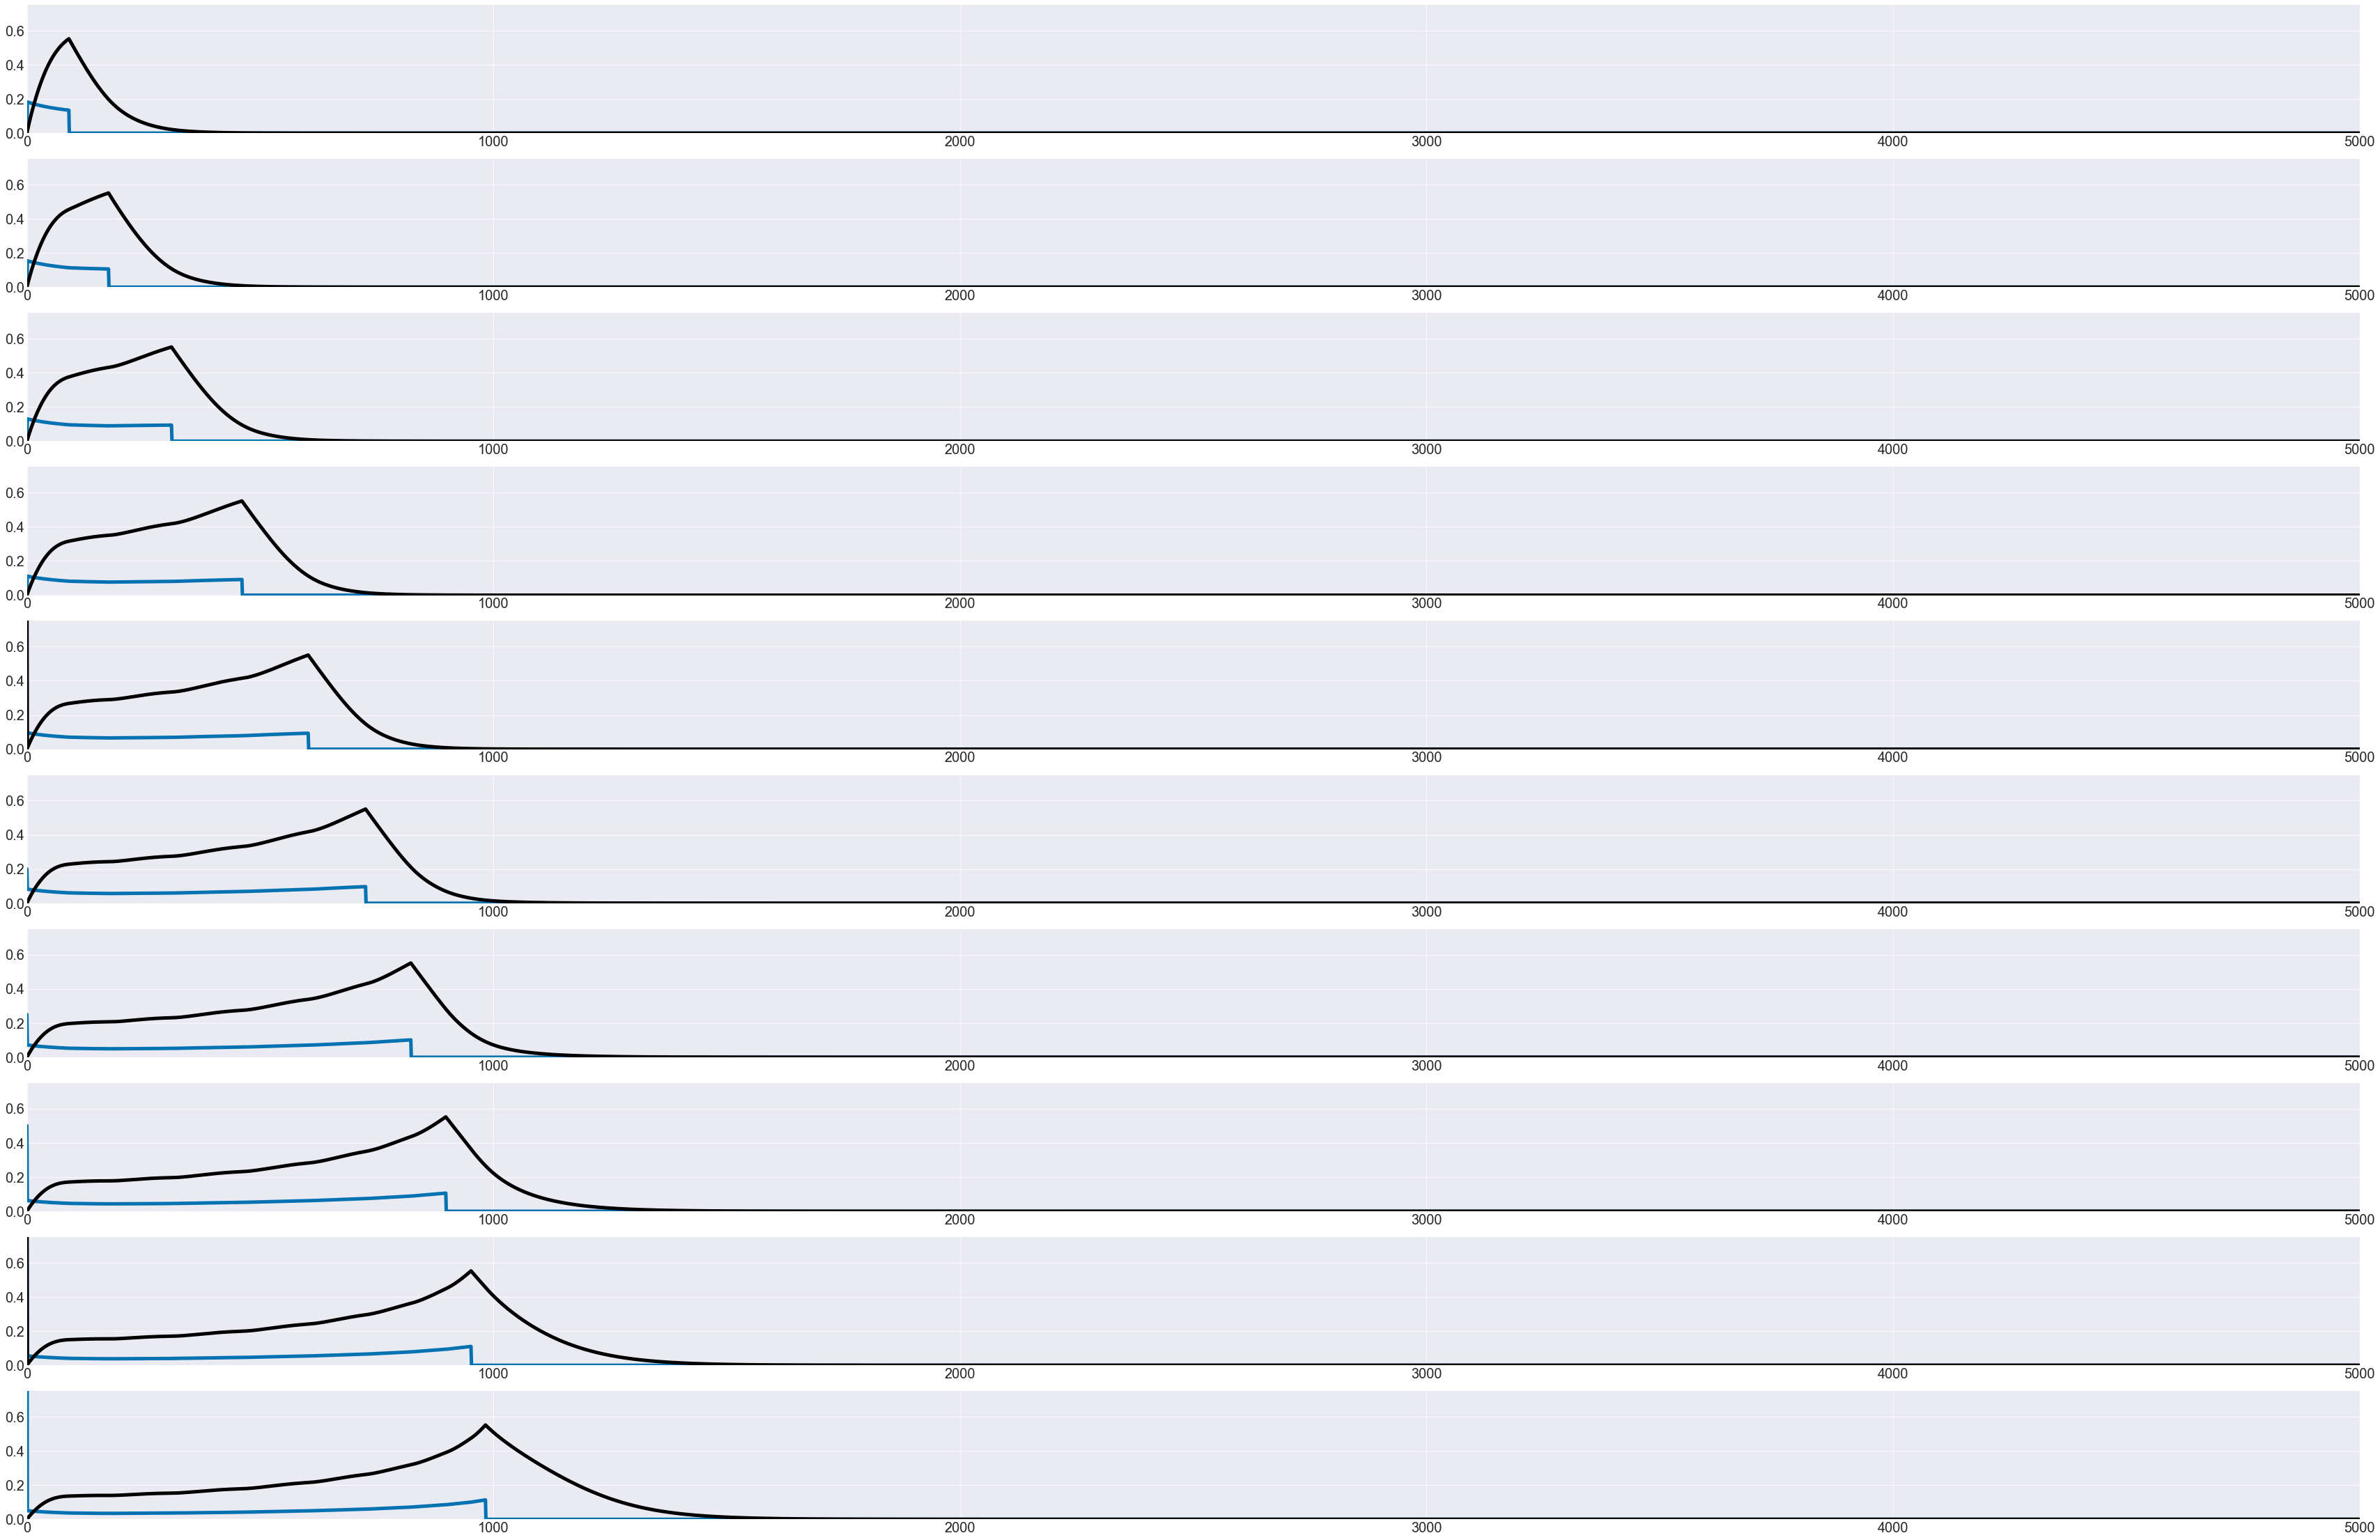

In [44]:
cqnet = cq.CQNet(num_gradients=10, timesteps=5000)
x_hist, y_hist, w_hist = cqnet.competitive_queue(I = cqnet.get_x(), decay_x=0.5, decay_y=1, decay_w=.01, capacity_x=1.0, capacity_y=2.0, capacity_w=1.0, feedback_strength = 1000, go_signal =3.5, lower_bound = 0, threshold = .55)
fig = plt.figure(figsize=(60, 40))

N = x_hist.shape[1]
for i in range(N): 
    a = fig.add_subplot(N, 1, i+1)
    a.plot(x_hist[:, i], lineWidth=5, label='working memory')
    a.set_ylim(ymin=0, ymax=.75)
    a.set_xlim(xmin=0, xmax=5000)
    a.plot(y_hist[:, i], c='black', lineWidth=5, label='RCF')

Look at the speed differences in recall between a go sigal of 1.9 and 3.5 on a scale of 5000 timesteps. As we increase the go signal, it forces a scalar increase in the winner take all layer, accelerating the speed which the neuron breaks the threshold. Generally, keeping the go signal at 1 makes sense, but this is a parameter that we can adjust to be the counterbalance to threshold. Now, let's find the more efficient speeder between the go signal and threshold. The threshold started to break down at about 100 timesteps in, can the go signal match that?

We are now going to raise the go signal to unstable levels to see how quick the net can be.

[0]
[0]
[0]
[0 1]
[1]
[2]
[2]
[3]
[3]
[4]
[5]
[6]
[7]
[8]
[9]


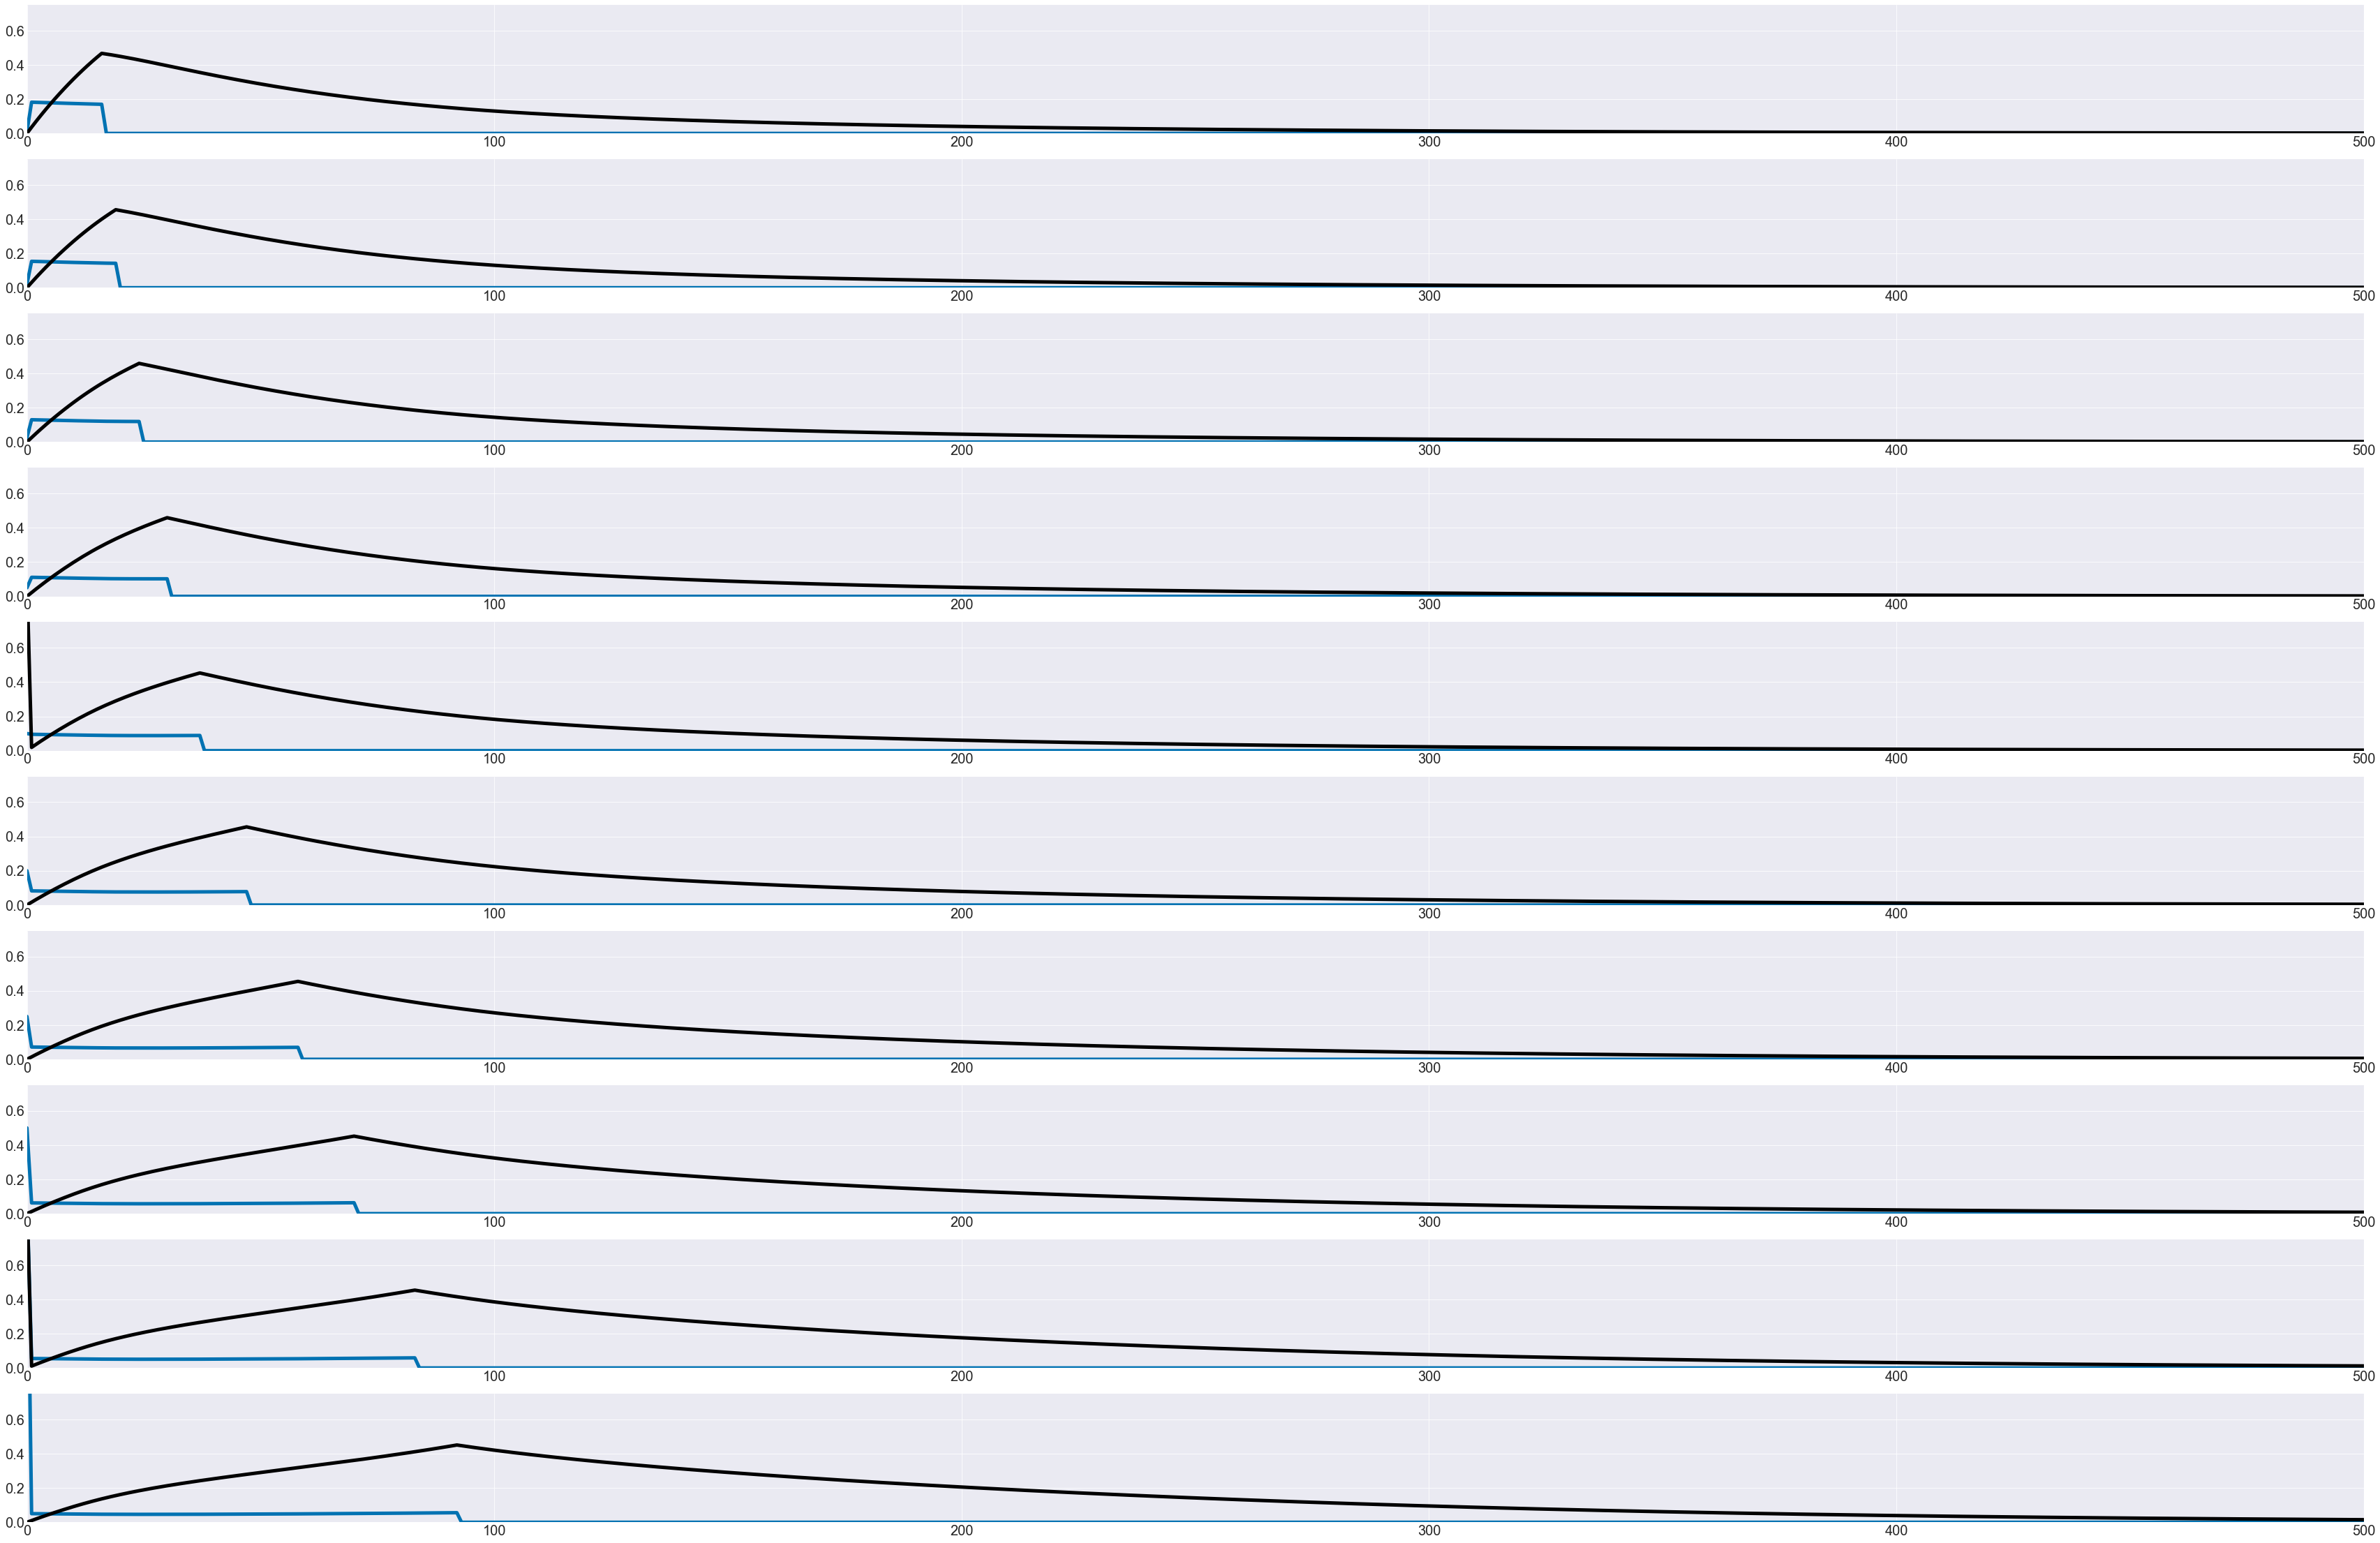

In [47]:
cqnet = cq.CQNet(num_gradients=10, timesteps=5000)
x_hist, y_hist, w_hist = cqnet.competitive_queue(I = cqnet.get_x(), decay_x=0.5, decay_y=1, decay_w=.01, capacity_x=1.0, capacity_y=2.0, capacity_w=1.0, feedback_strength = 1000, go_signal =10, lower_bound = 0, threshold = .45)
fig = plt.figure(figsize=(60, 40))

N = x_hist.shape[1]
for i in range(N): 
    a = fig.add_subplot(N, 1, i+1)
    a.plot(x_hist[:, i], lineWidth=5, label='working memory')
    a.set_ylim(ymin=0, ymax=.75)
    a.set_xlim(xmin=0, xmax=500)
    a.plot(y_hist[:, i], c='black', lineWidth=5, label='RCF')

With a go signal of 10, effectively a magnitude scalar, we get instability. This happens at about the same number of timesteps that the threshold gets noticeably unstable. With more primacy gradients, it is likely we would see earlier instability but with 10 primacy gradients, this is pretty good. This suggests that neurons can only fire so quickly before a break down in structure because their signals get mixed up and too many fire simultaneuously. This would be interesting to test in a biological brain to see if that is the same case. Simply hypothesizing here, this could be a limiting factor in biological brain speed, the speed of stable short term recall. Adjusting the threshold and go-signal prove to provide speed increases at the cost of stability. 

### 3. Serial recall with different working memory representations
Experiment with competitive queuing with bowed and recency gradients. How happens and does it make sense?

### 4. Other visual illusions

Look up other grayscale brightness-related visual illusions online and simulate them with your networks (e.g. convolutional, RCF, etc.) Is your network able to account for them? I suggest picking simple ones. 

### 5. Color image enhancement

Design a shunting network that enhances color images.

### 6. Simulate other network properties

Simulate properties of shunting networks from class that you have not directly simulated.